## Prepare Notebook

In [22]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns

from jax import random
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer.util import initialize_model, Predictive
from sklearn.preprocessing import StandardScaler


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Synthetic Data

In [18]:
n = 200
rng_key, rng_subkey = random.split(rng_key)
x = random.uniform(rng_key, shape=(n,), minval=1, maxval=jnp.pi)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

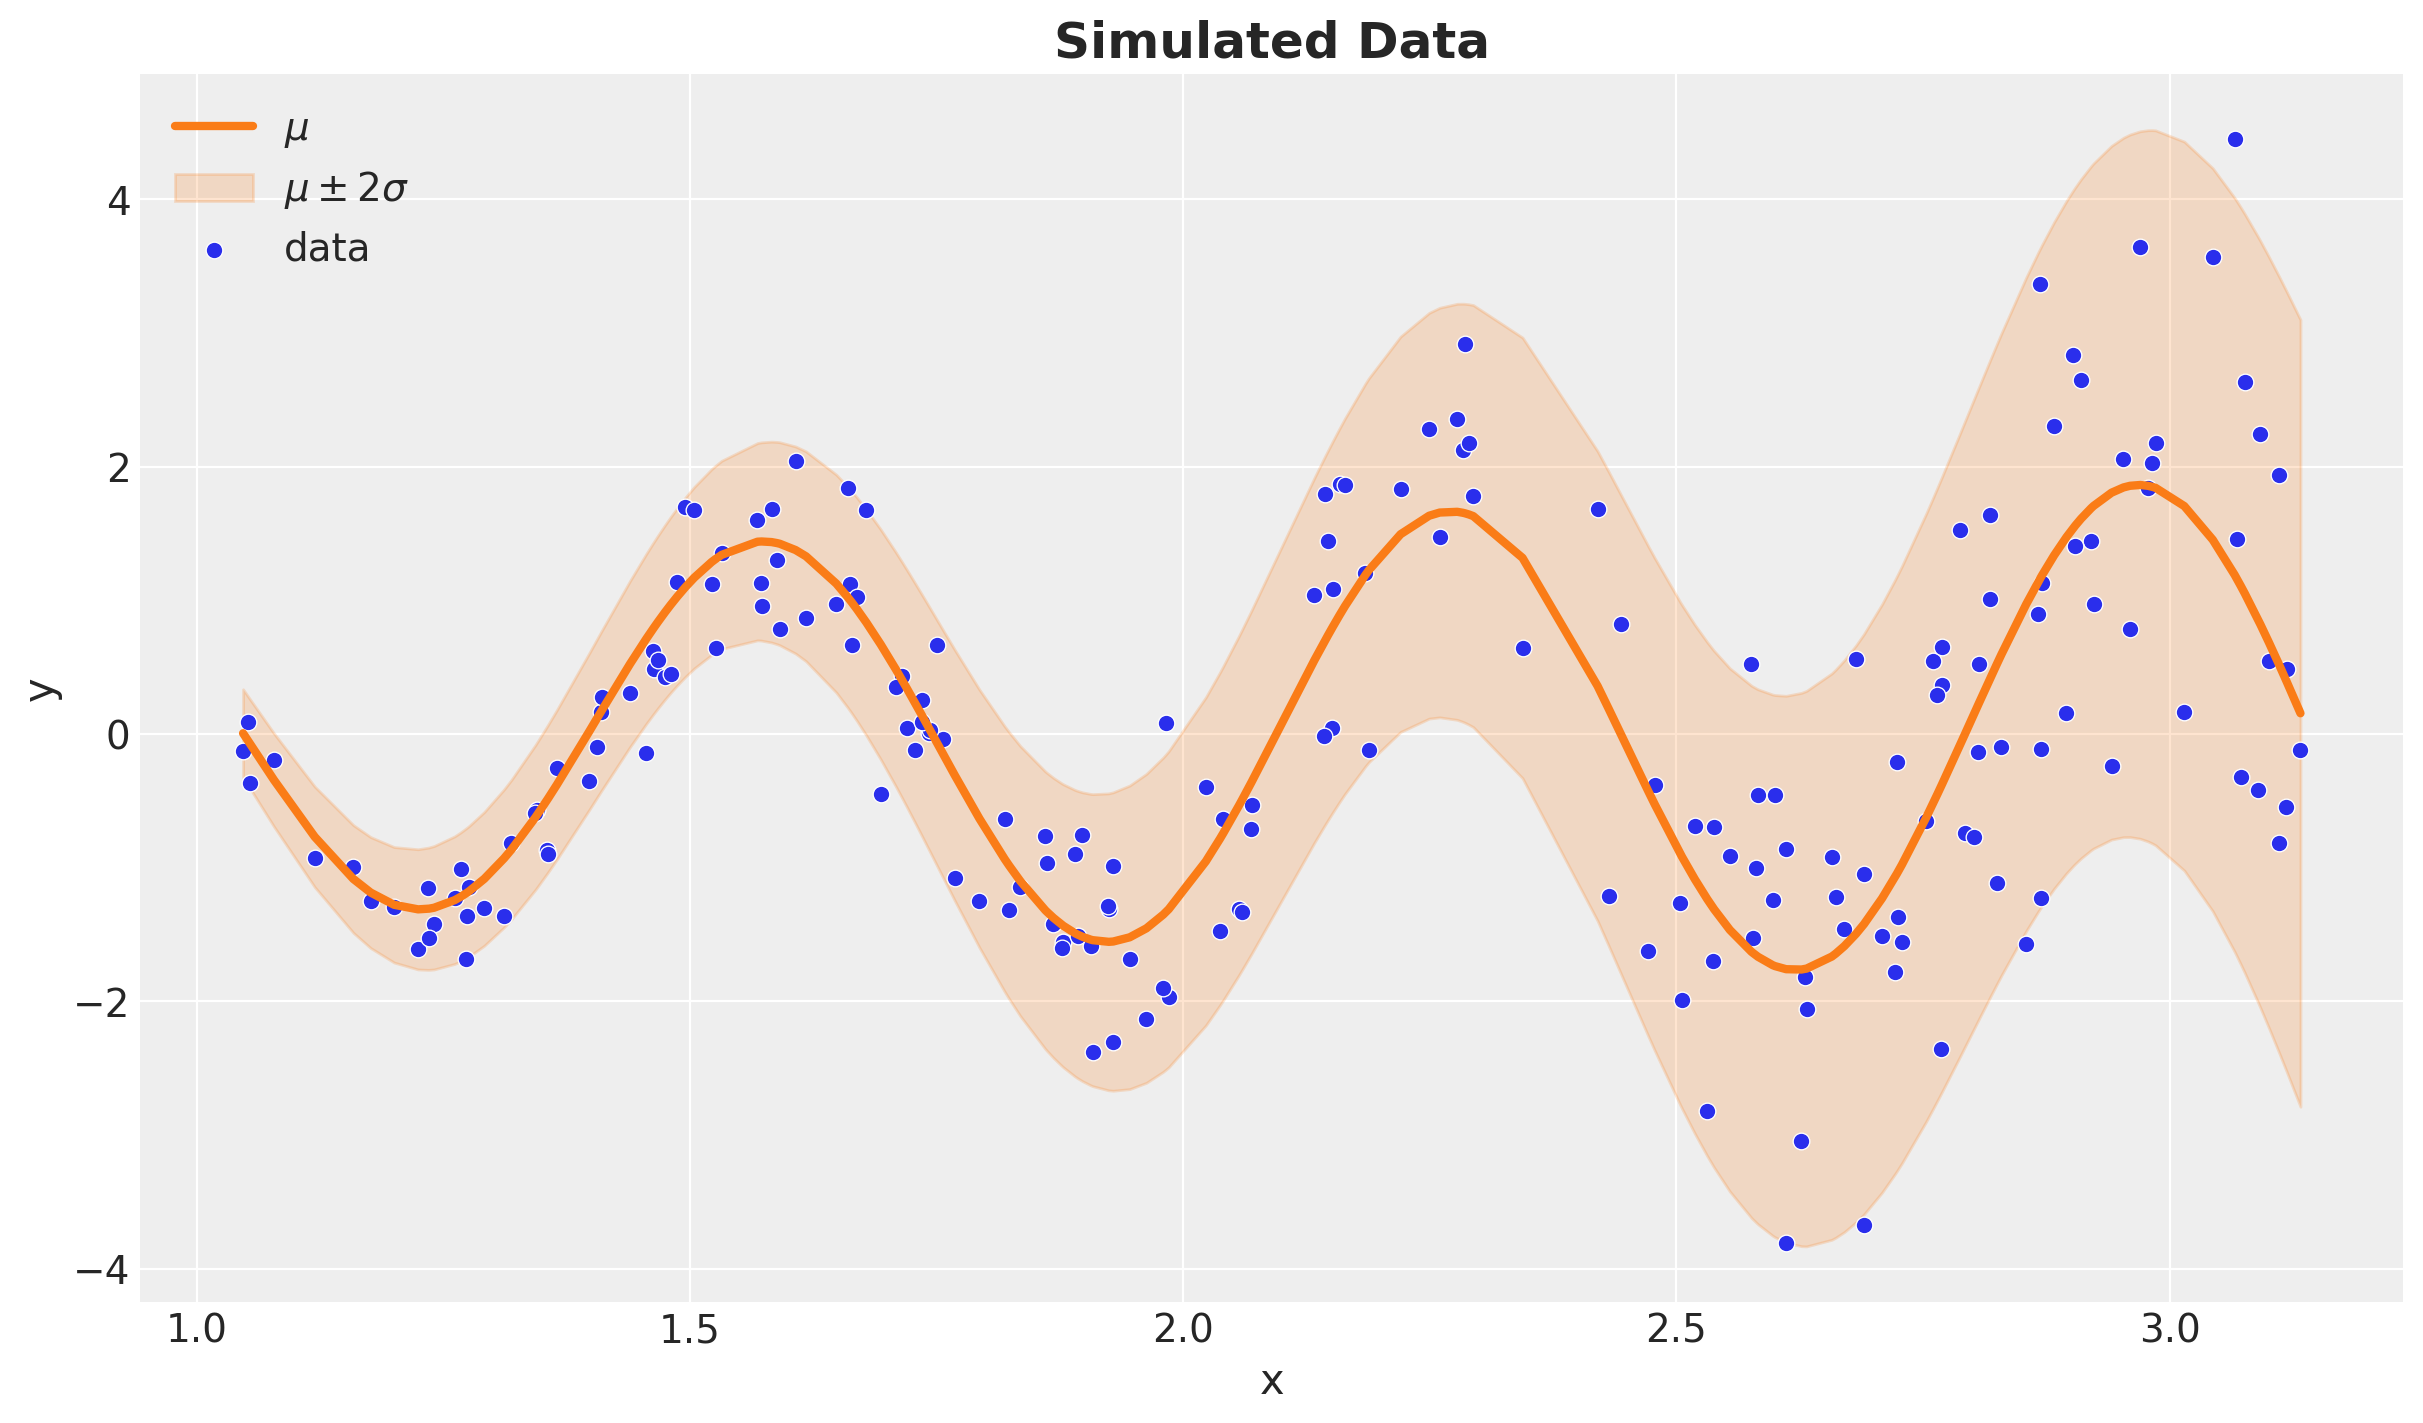

In [19]:
x_idx = jnp.argsort(x)

fig, ax = plt.subplots()
sns.lineplot(x=x, y=mu_true, color="C1", label=r"$\mu$", linewidth=3, ax=ax)
ax.fill_between(
    x[x_idx],
    (mu_true - 2 * sigma_true)[x_idx],
    (mu_true + 2 * sigma_true)[x_idx],
    color="C1",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
sns.scatterplot(x=x, y=y, color="C0", label="data", ax=ax)
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

In [20]:
train_test_split = 0.7
train_idx = int(n * train_test_split)
x_train, y_train = x[:train_idx], y[:train_idx]
x_test, y_test = x[train_idx:], y[train_idx:]

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

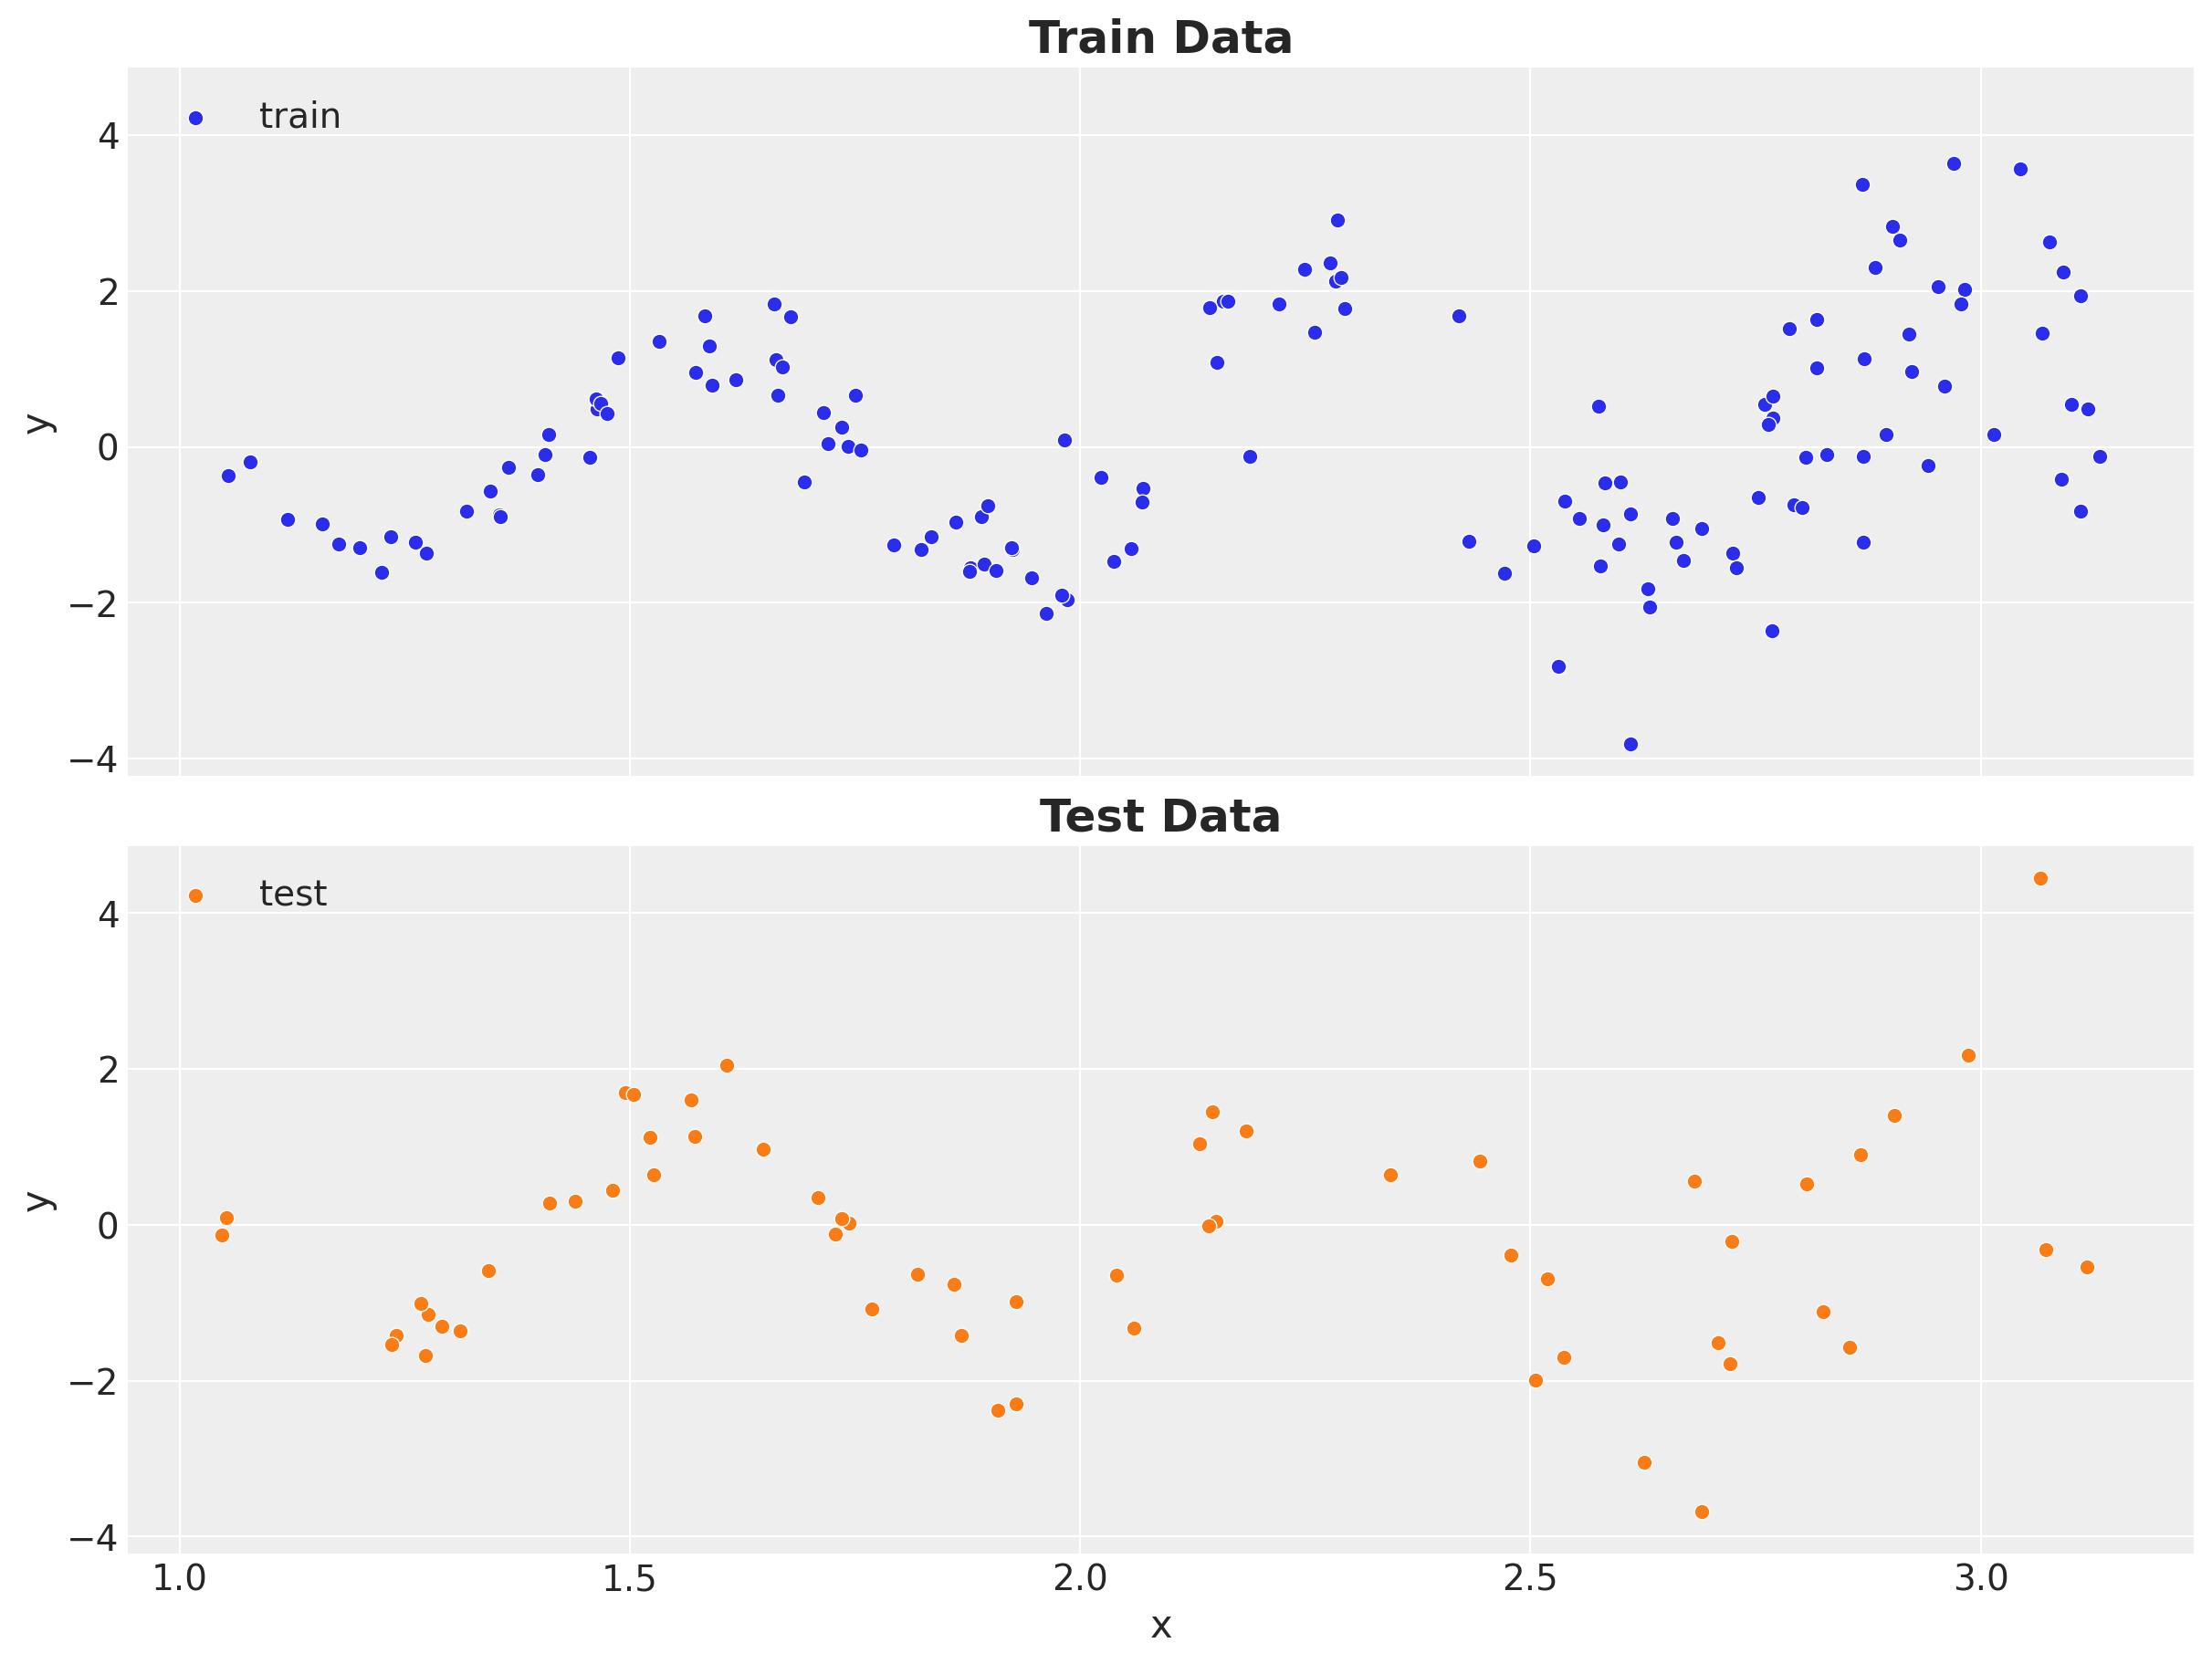

In [21]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train, y=y_train, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test, y=y_test, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Data Preprocessing

In [25]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train[:, None])
x_train_scaled = x_train_scaled.squeeze()
x_test_scaled = x_scaler.transform(x_test[:, None])
x_test_scaled = x_test_scaled.squeeze()

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train[:, None])
y_train_scaled = y_train_scaled.squeeze()
y_test_scaled = y_scaler.transform(y_test[:, None])
y_test_scaled = y_test_scaled.squeeze()

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

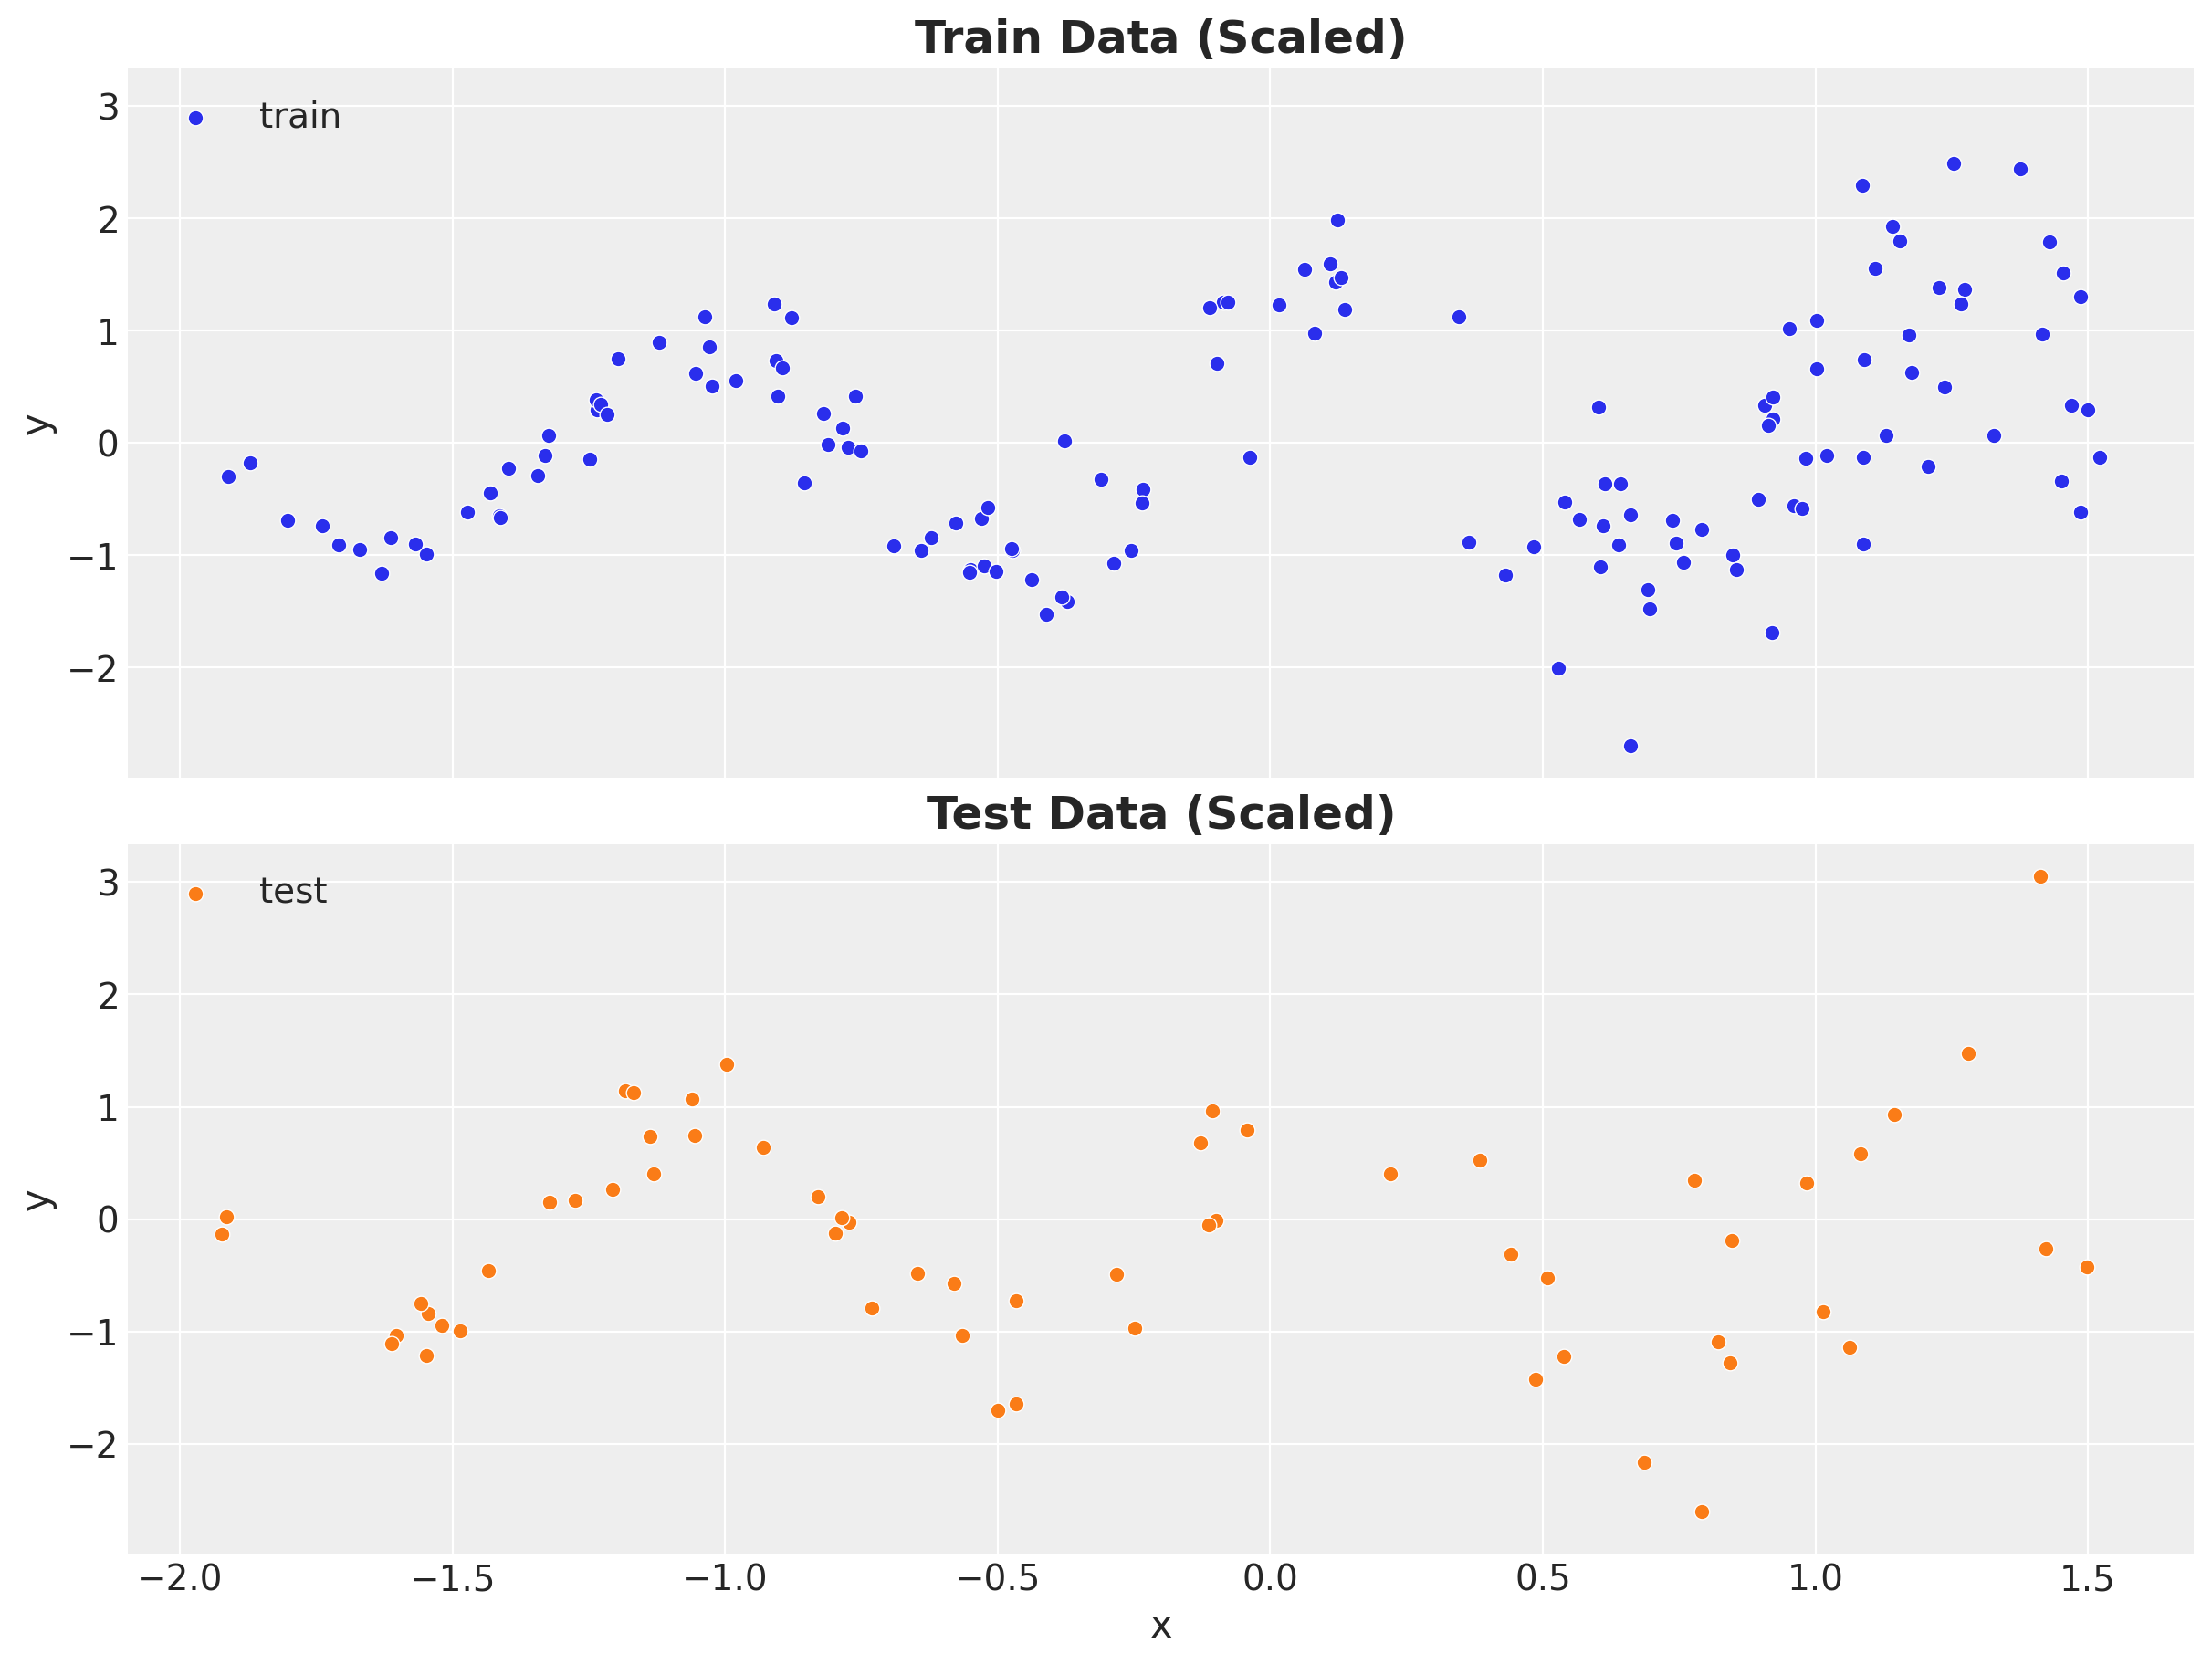

In [26]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train_scaled, y=y_train_scaled, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test_scaled, y=y_test_scaled, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data (Scaled)", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")